In [2]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models, optimizers
import pandas as pd
from PIL import Image   


In [3]:
from tensorflow.keras.preprocessing.image import smart_resize


In [111]:
IMAGE_SIZE = (48, 48)
RE_SIZE = (128, 128)
BATCH_SIZE = 32

In [112]:
def build_dataset(subset, data):
    return tf.keras.preprocessing.image_dataset_from_directory(
                        "archive/"+f"{data}",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=BATCH_SIZE,
                        seed=16,
                        validation_split=0.2,
                        subset=subset)

In [113]:
train_ds, val_ds = build_dataset("both", "train")
class_names = train_ds.class_names

Found 28097 files belonging to 7 classes.
Using 22478 files for training.
Using 5619 files for validation.


In [114]:
#preprocess the data
norm_layer = layers.Rescaling(1./255)

norm_model = keras.Sequential([norm_layer])

train_ds = train_ds.map(lambda x, y: (norm_model(x), y))
val_ds = val_ds.map(lambda x, y: (norm_model(x), y))

In [115]:
#image adjust_contrast
train_ds = train_ds.map(lambda x, y: (tf.image.adjust_contrast(x, 5), y))
val_ds = val_ds.map(lambda x, y: (tf.image.adjust_contrast(x, 5), y))

In [82]:
#Create weight for the classes based on the number of samples
class_weights = {}

for image, label in train_ds:
    label = np.argmax(label)
    if label not in class_weights:
        class_weights[label] = 0
    class_weights[label] += 1

# Calculate the class weights
total = sum(class_weights.values())

for label in class_weights:
    class_weights[label] = total / class_weights[label]

print(class_weights)

{3: 3.868131868131868, 0: 7.183673469387755, 5: 6.175438596491228, 4: 7.183673469387755, 2: 6.068965517241379, 6: 8.380952380952381, 1: 58.666666666666664}


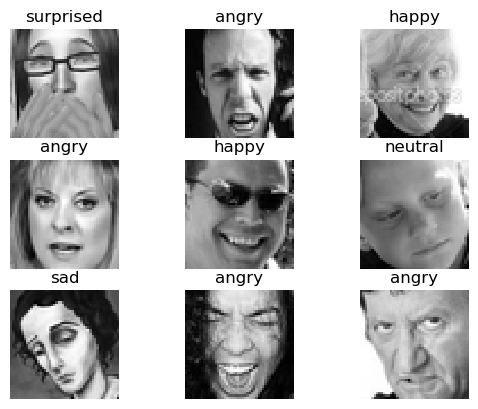

In [83]:
#display an image
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i], cmap='gray', interpolation='none')
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

In [116]:
#Define horisontal and vertical kernels for convolution 3 by 3
#horizontal_kernel = np.array([[-1, -1, -1], [0,0,0], [1,1,1]])
#vertical_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
#cross_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
#Define the convolutional layer with the kernels 
conv_layer = layers.Conv2D(6, (3, 3))
#kernels = np.array([horizontal_kernel, vertical_kernel, cross_kernel])
#kernels = np.expand_dims(kernels, axis=-2)
kernels_weight = np.asarray([
    [[[-1, -1, -1, 0, 2, 0]], [[-1, 0, -1, 1, 1, 0]], [[-1,1,-1, 2, 0, 0]]],
    [[[0, -1, -1, -1, 1, 0]], [[0, 0, 8, 0, 0, 1]], [[0, 1, -1, 1, -1, 0]]],
    [[[1, -1, -1, -2, 0, 0]], [[1, 0, -1, -1, -1, 0]], [[1, 1, -1, 0, -2, 0]]]
])
conv_layer.build((None, 48, 48, 1))
conv_layer.set_weights([kernels_weight, np.zeros(6)])


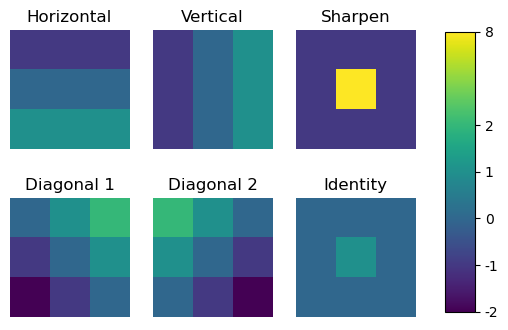

In [117]:
#plot the kernels
fig, axs = plt.subplots(2, 3, figsize=(6, 4))
names_kernels = ["Horizontal", "Vertical", "Sharpen", 'Diagonal 1', 'Diagonal 2', 'Identity']
for i in range(6):
    ax = axs[i//3, i%3]
    ax.imshow(kernels_weight[:,:,0,i], cmap='viridis', vmin = -2, vmax = 4)
    ax.axis("off")
    ax.set_title(f"{names_kernels[i]}")
#colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(axs[0, 0].imshow(kernels_weight[:,:,0,0], cmap='viridis', vmin = -2, vmax = 4), cax=cbar_ax, orientation='vertical', ticks=[-2, -1, 0, 1, 2, 4])
cbar.ax.set_yticklabels(['-2', '-1', '0', '1', '2', '8'])
plt.savefig("pics/kernels.png")

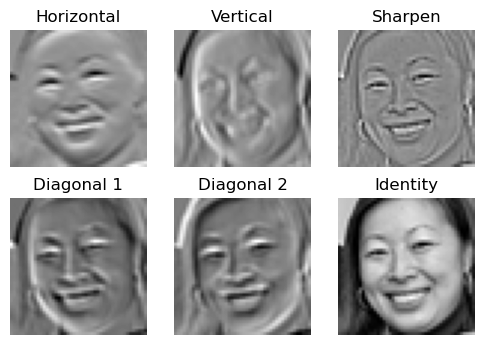

In [118]:
#plot the result of the convolution
img_kern = plt.imread('archive/train/happy/im47.png')
img_kern = img_kern/255
img_kern = np.expand_dims(img_kern, axis=-1)
img_kern = np.expand_dims(img_kern, axis=0)
conv_img = conv_layer(img_kern)

fig, axs = plt.subplots(2, 3, figsize=(6, 4))
for i in range(6):
    ax = axs[i//3, i%3]
    ax.imshow(conv_img[0,:,:,i], cmap='gray')
    ax.axis("off")
    ax.set_title(f"{names_kernels[i]}")
plt.savefig("pics/convolution.png")

In [119]:
model = tf.keras.models.Sequential([
    keras.Input(shape=(*IMAGE_SIZE, 1)),
    conv_layer,
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), 
    layers.Dense(7, activation='softmax')
])

In [120]:
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 46, 46, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 44, 44, 128)    │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 20, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,803 (909.39 KB)

 Trainable params: 232,803 (909.39 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
#train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


703/703 ━━━━━━━━━━━━━━━━━━━━ 132s 181ms/step - accuracy: 0.3023 - loss: 1.8080 - val_accuracy: 0.4040 - val_loss: 1.5124
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 120s 170ms/step - accuracy: 0.4409 - loss: 1.4496 - val_accuracy: 0.4659 - val_loss: 1.3778
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 135s 159ms/step - accuracy: 0.4878 - loss: 1.3375 - val_accuracy: 0.4842 - val_loss: 1.3477
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 118s 167ms/step - accuracy: 0.5279 - loss: 1.2567 - val_accuracy: 0.4974 - val_loss: 1.3273
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 115s 164ms/step - accuracy: 0.5509 - loss: 1.1968 - val_accuracy: 0.5015 - val_loss: 1.3154
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.5701 - loss: 1.1340 - val_accuracy: 0.5035 - val_loss: 1.3742
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 141s 163ms/step - accuracy: 0.5963 - loss: 1.0684 - val_accuracy: 0.4842 - val_loss: 1.4488
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 149s 172ms/step - accuracy: 0.6244 - loss: 1.00

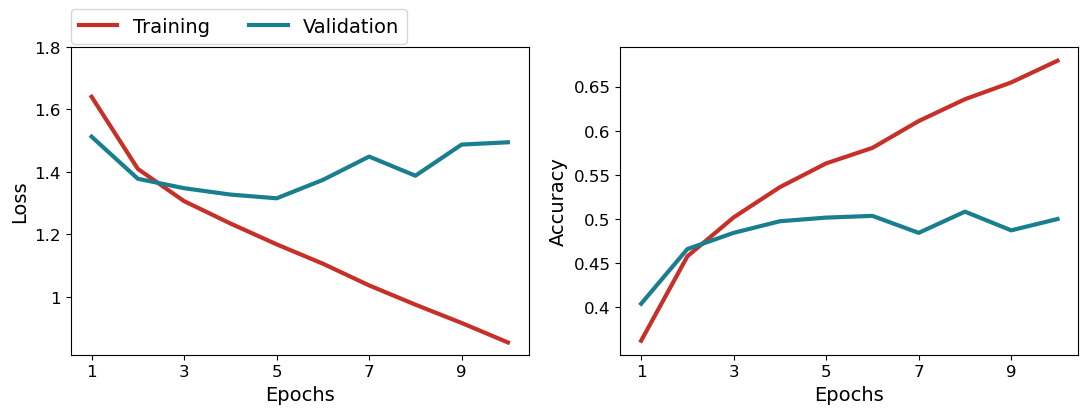

In [123]:
lw = 3
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(history.history['loss'], label='Training', c = '#c73028', lw = lw)
axs[0].plot(history.history['val_loss'], label='Validation', c = '#197f8e', lw = lw)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(loc = (0, 1.01), ncol=3, fontsize= 14)
axs[0].set_xticks(np.arange(0, 10, 2))
axs[0].set_xticklabels(np.arange(1, 11, 2), fontsize=12)
axs[0].set_yticks(np.arange(1, 1.9, 0.2))
axs[0].set_yticklabels([1, 1.2, 1.4, 1.6, 1.8], fontsize=12)


axs[1].plot(history.history['accuracy'], label='Training', c = '#c73028', lw = lw)
axs[1].plot(history.history['val_accuracy'], label='Validation', c = '#197f8e', lw = lw)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xticks(np.arange(0, 10, 2))
axs[1].set_xticklabels(np.arange(1, 11, 2), fontsize=12)
axs[1].set_yticks(np.arange(0.4, 0.66, 0.05))
axs[1].set_yticklabels([0.4, 0.45, 0.5, 0.55, 0.6, 0.65], fontsize=12)
plt.savefig('pics/training_native_full.png', dpi=300, bbox_inches='tight')

In [19]:
#Evaluate test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/test",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=16) 

test_ds = test_ds.map(lambda x, y: (norm_model(x), y))


Found 7178 files belonging to 7 classes.


In [124]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy", test_acc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.4167 - loss: 1.5441
Test accuracy 0.4218445122241974


In [21]:
#Produce a cm across all classes
def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / tf.reduce_sum(cm, axis=1)[:, None]
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)

In [22]:
def get_confusion_matrix(model, test_ds):
    all_labels = []
    all_preds = []

    for x, y in test_ds:
        all_labels.append(np.argmax(y, axis=1))
        all_preds.append(np.argmax(model.predict(x), axis=1))

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return tf.math.confusion_matrix(all_labels, all_preds)

In [125]:
cm = get_confusion_matrix(model, test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106

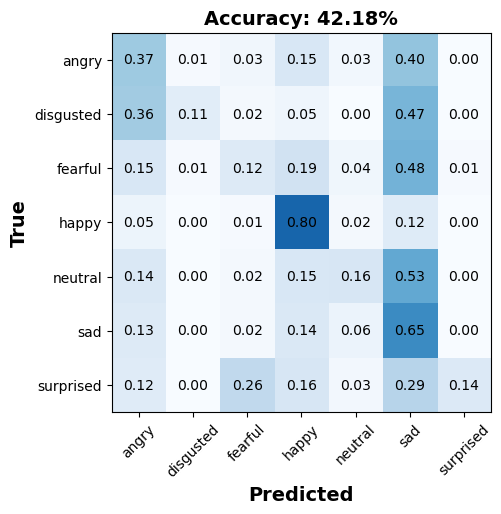

In [126]:
plot_confusion_matrix(cm, class_names)
plt.savefig("pics/cm_native.png", dpi=300, bbox_inches='tight')

In [25]:
#visualize the final model


In [26]:
#Save the model
#model.save("tf_native.keras")

In [27]:
#load a new dataset from the emotions file 
#Without the subfolders discarded anf free
test_ds_em = tf.keras.preprocessing.image_dataset_from_directory(
    "emotions",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=16)
    


Found 404 files belonging to 7 classes.


In [28]:
test_ds_em = test_ds_em.map(lambda x, y: (norm_model(x), y))


In [29]:
#Evaluate the new dataset
test_loss, test_acc = model.evaluate(test_ds_em)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1839 - loss: 2.0069


In [30]:
#Produce a cm across all classes
cm = get_confusion_matrix(model, test_ds_em)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


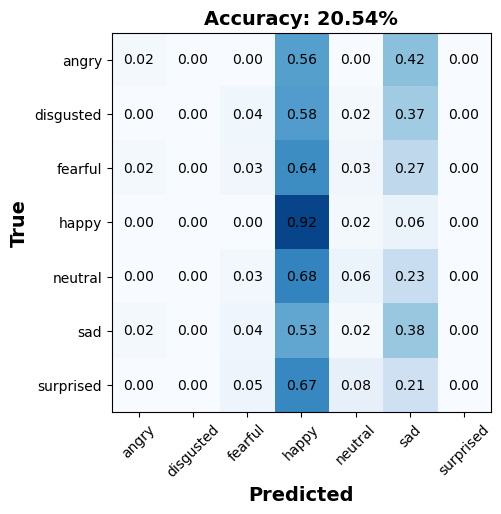

In [31]:
plot_confusion_matrix(cm, class_names)
#plt.savefig("cm_pic_v2.png")

In [32]:
#Inspect the training data and print the number of pictures in each subfolder
import os


In [33]:
def count_files(path):
    return sum([len(files) for r, d, files in os.walk(path)])


In [34]:
print("Number of files in each subfolder")
print("Training")
print(count_files("archive/train"))
for i in range(7):
    print(class_names[i], count_files("archive/train/"+class_names[i]))
print("Validation")
print(count_files("archive/test"))
for i in range(7):
    print(class_names[i], count_files("archive/test/"+class_names[i]))

Number of files in each subfolder
Training
28097
angry 3995
disgusted 436
fearful 4097
happy 7215
neutral 4353
sad 4830
surprised 3171
Validation
7178
angry 958
disgusted 111
fearful 1024
happy 1774
neutral 1233
sad 1247
surprised 831


In [35]:
#Define color 
uni_red = (144, 26, 30)

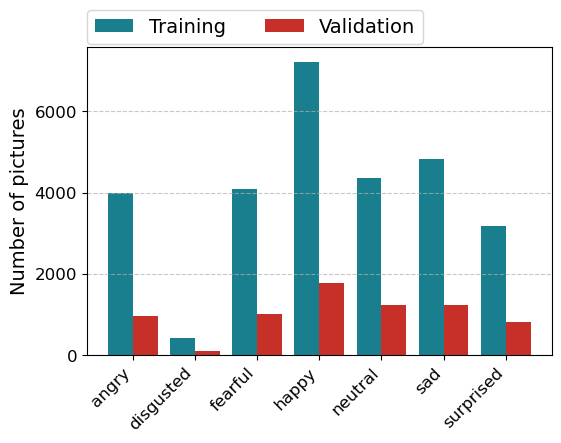

In [36]:
#Create a histogram of the number of pictures in each subfolder
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(axis='y', linestyle='--', alpha=0.7)
width = 0.4
train_counts = [count_files("archive/train/"+class_names[i]) for i in range(7)]
val_counts = [count_files("archive/test/"+class_names[i]) for i in range(7)]
ax.bar(np.arange(7)-width/2, train_counts, width, label="Training", color='#197f8e')
ax.bar(np.arange(7)+width/2, val_counts, width, label="Validation", color='#c73028')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(class_names, rotation=45, fontsize=12, ha='right')
ax.set_yticks(np.arange(0, 7000, 2000))
ax.set_yticklabels(np.arange(0, 7000, 2000), fontsize=12)
ax.set_ylabel("Number of pictures", fontsize=14)
ax.legend(loc = (0, 1.01), ncol=2, fontsize= 14)
plt.savefig('pics/N_pics.png', dpi=300, bbox_inches='tight')

In [37]:
pic_names = ["angry/im30.png", "disgusted/im100.png", "fearful/im5.png", "happy/im47.png", "neutral/im112.png", "sad/im17.png", "surprised/im54.png"]

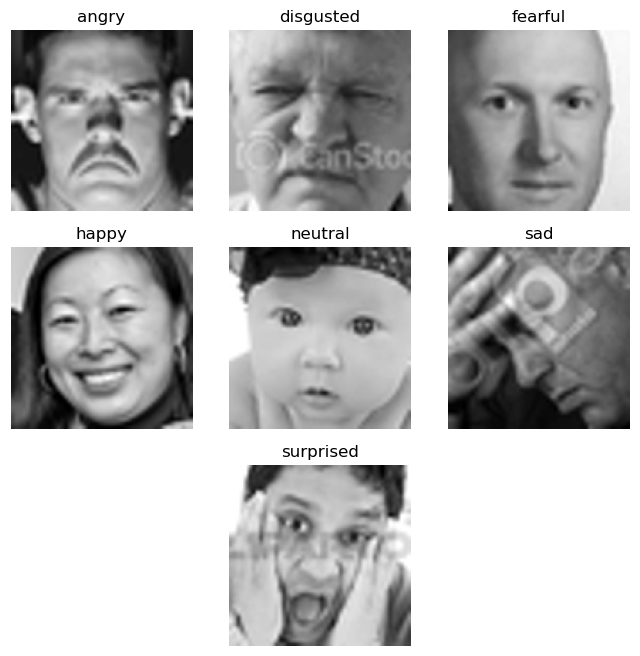

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(6):
    ax = axs[i//3, i%3]
    img = Image.open("archive/train/"+pic_names[i])
    img = img.resize(RE_SIZE)
    ax.imshow(img, cmap='gray')
    ax.axis("off")
    ax.set_title(f"{class_names[i]}")
axs[2, 2].axis("off")
axs[2, 0].axis("off")
img = Image.open("archive/test/"+pic_names[6])
img = img.resize(RE_SIZE)
axs[2, 1].imshow(img, cmap='gray')
axs[2, 1].axis("off")
axs[2, 1].set_title(f"{class_names[6]}")
plt.savefig('pics/examples.png', dpi=300, bbox_inches='tight')

(0.0, 1.0, 0.0, 1.0)

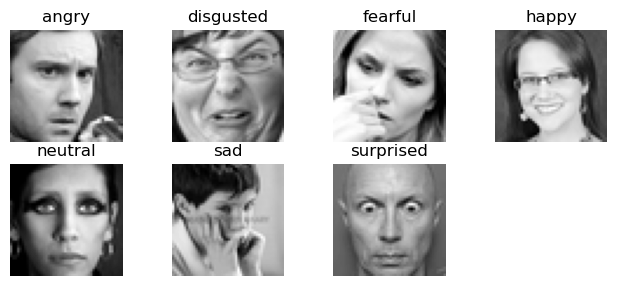

In [39]:
#Plot an example of each class
fig, axs = plt.subplots(2, 4, figsize=(8, 3.2))
for i in range(7):
    ax = axs[i//4, i%4]
    ax.grid(False)
    ax.axis('off')
    ax.imshow(plt.imread("archive/train/"+class_names[i]+"/"+os.listdir("archive/train/"+class_names[i])[0]), cmap='gray')
    ax.set_title(class_names[i], fontsize=12)
axs[1, 3].axis('off')


In [40]:
#Perform the same training but only on 'angry', 'happy', 'neutral', 'sad' and 'surprised'

In [41]:
names_subset = ['angry', 'happy', 'neutral', 'sad', 'surprised']

In [42]:
train_ds2, val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
                        "archive/train/",
                        class_names = names_subset,
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=BATCH_SIZE,
                        seed=16,
                        validation_split=0.2,
                        subset='both')

Found 23564 files belonging to 5 classes.
Using 18852 files for training.
Using 4712 files for validation.


In [43]:
train_ds2 = train_ds2.map(lambda x, y: (norm_model(x), y))
val_ds2 = val_ds2.map(lambda x, y: (norm_model(x), y))


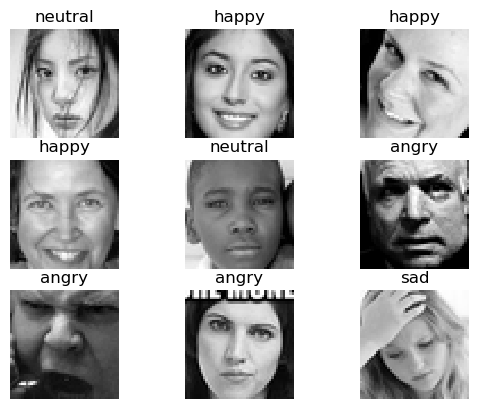

In [44]:
#display an image
for image, label in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i], cmap='gray', interpolation='none')
        plt.title(names_subset[np.argmax(label[i])])
        plt.axis("off")

In [45]:
model2 = tf.keras.models.Sequential([
    keras.Input(shape=(*IMAGE_SIZE, 1)),
    conv_layer,
    layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'), 
    layers.Dense(5, activation='softmax')
])

In [46]:
model2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [47]:
model2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,209 (578.94 KB)

 Trainable params: 148,209 (578.94 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history2 = model2.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=10
)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.3306 - loss: 1.5297 - val_accuracy: 0.4329 - val_loss: 1.3448
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.4676 - loss: 1.2878 - val_accuracy: 0.5306 - val_loss: 1.1625
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.5250 - loss: 1.1738 - val_accuracy: 0.5427 - val_loss: 1.1246
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.5561 - loss: 1.0989 - val_accuracy: 0.5533 - val_loss: 1.0965
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.5865 - loss: 1.0289 - val_accuracy: 0.5821 - val_loss: 1.0462
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.6083 - loss: 0.9811 - val_accuracy: 0.5919 - val_loss: 1.0150
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.6296 - loss: 0.9422 - val_accuracy: 0.5991 - val_loss: 1.0157
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.6442 - loss: 0.9013 - 

In [49]:
#Save the model
#model2.save("tf_krebs_subset.keras")

In [50]:
test_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/test",
    class_names = names_subset,
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=16)

Found 6043 files belonging to 5 classes.


In [51]:
test_ds2 = test_ds2.map(lambda x, y: (norm_model(x), y))


In [52]:
test_loss, test_acc = model2.evaluate(test_ds2)
print("Test accuracy", test_acc)


189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5942 - loss: 1.0486
Test accuracy 0.6000331044197083


In [127]:
cm = get_confusion_matrix(model2, test_ds2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━

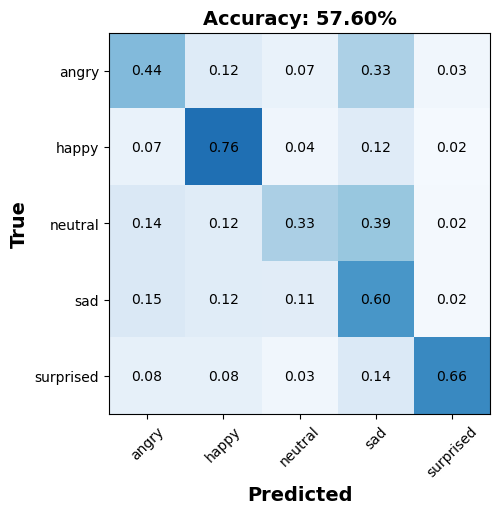

In [129]:
plot_confusion_matrix(cm, names_subset)
plt.savefig("pics/cm_subset.png", dpi=300, bbox_inches='tight')

In [55]:
#Test on the emotions dataset
test_ds_em2 = tf.keras.preprocessing.image_dataset_from_directory(
    "emotions",
    class_names = names_subset,
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=16)

Found 293 files belonging to 5 classes.


In [56]:
test_ds_em2 = test_ds_em2.map(lambda x, y: (norm_model(x), y))


In [57]:
test_loss, test_acc = model2.evaluate(test_ds_em2)
print("Test accuracy", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3738 - loss: 1.9386
Test accuracy 0.41296929121017456


In [58]:
cm = get_confusion_matrix(model2, test_ds_em2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


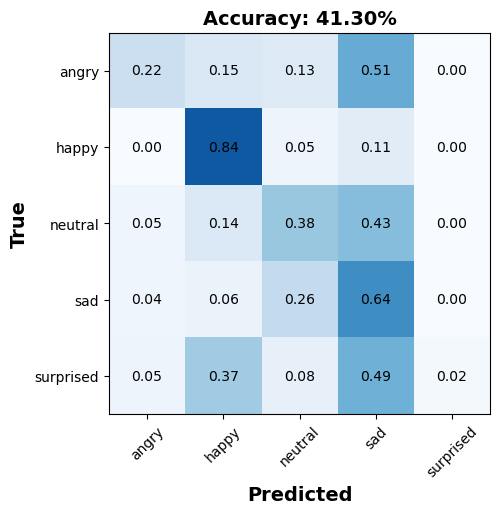

In [59]:
plot_confusion_matrix(cm, names_subset)

In [60]:
history.history

{'accuracy': [0.3698727786540985,
  0.44955065846443176,
  0.4893229007720947,
  0.5217990875244141,
  0.5547201633453369,
  0.578521192073822,
  0.607705295085907,
  0.6393362283706665,
  0.6693211197853088,
  0.6971260905265808],
 'loss': [1.617801308631897,
  1.431137204170227,
  1.325282335281372,
  1.2484805583953857,
  1.1738834381103516,
  1.1049580574035645,
  1.034324288368225,
  0.9624253511428833,
  0.8886203765869141,
  0.814613938331604],
 'val_accuracy': [0.4153763949871063,
  0.45239365100860596,
  0.47481757402420044,
  0.4851396977901459,
  0.4789108335971832,
  0.47837692499160767,
  0.4888770282268524,
  0.4628937542438507,
  0.4945719838142395,
  0.48407191038131714],
 'val_loss': [1.516249656677246,
  1.4151461124420166,
  1.3736467361450195,
  1.3456259965896606,
  1.3891024589538574,
  1.3736401796340942,
  1.398078441619873,
  1.5142723321914673,
  1.460755705833435,
  1.5732548236846924]}

In [131]:
emilie_finetuning = pd.read_csv("all_data_incl_finetuning.csv")
emilie_no_finetuning = pd.read_csv("all_data_without_finetuning.csv")
simon_finetuning = pd.read_csv("ResNet50V2_newDay_v3_63acc.csv")
simon_no_finetuning = pd.read_csv("hist_ResNet50V2_nofinetuning.csv")
em_small_ = pd.read_csv('smalldataset_incl_finetuning-2.csv')
joey = pd.read_csv('loss_lux.csv')

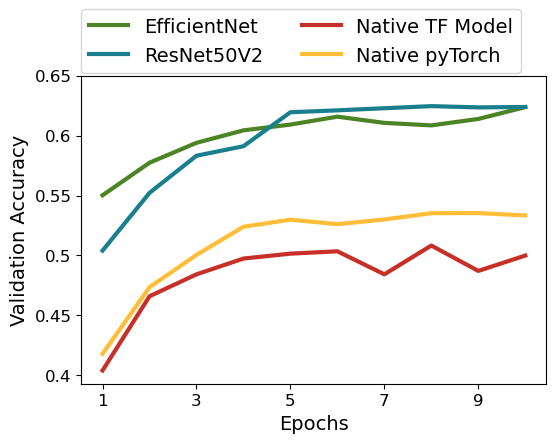

In [132]:
#plot the change in validation loss and accuracy as a function of epochs
lw = 3
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.plot(emilie_finetuning['val_accuracy'], label='EfficientNet', c = '#4b8325', lw = lw)
ax.plot(simon_finetuning['val_accuracy'], label='ResNet50V2', c = '#197f8e', lw = lw)
ax.plot(history.history['val_accuracy'], label='Native TF Model', c = '#c73028', lw = lw)
ax.plot(joey['val_acc'], label='Native pyTorch', c = '#ffbd38', lw = lw)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Validation Accuracy', fontsize=14)
ax.set_xticks(np.arange(0, 10, 2))
ax.set_xticklabels(np.arange(1, 11, 2), fontsize=12)
ax.set_yticks(np.arange(0.4, 0.66, 0.05))
ax.set_yticklabels([0.4, 0.45, 0.5, 0.55, 0.6, 0.65], fontsize=12)
ax.legend(loc = (0, 1.01), ncol=2, fontsize= 14)
plt.savefig('pics/compare_models.png', dpi=300, bbox_inches='tight')


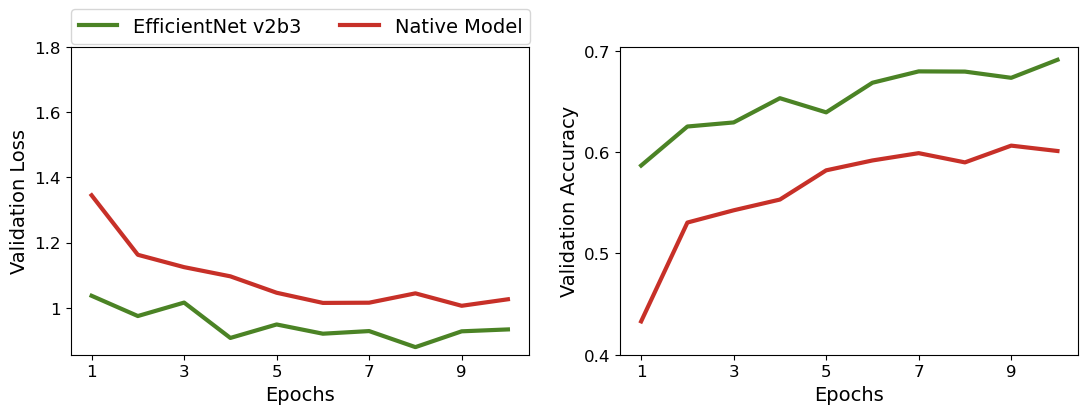

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(em_small_['val_loss'], label='EfficientNet v2b3', c = '#4b8325', lw = lw)
ax[0].plot(history2.history['val_loss'], label='Native Model', c = '#c73028', lw = lw)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Validation Loss', fontsize=14)
ax[0].legend(loc = (0, 1.01), ncol=2, fontsize= 14)
ax[0].set_xticks(np.arange(0, 10, 2))
ax[0].set_xticklabels(np.arange(1, 11, 2), fontsize=12)
ax[0].set_yticks(np.arange(1, 1.9, 0.2))
ax[0].set_yticklabels([1, 1.2, 1.4, 1.6, 1.8], fontsize=12)

ax[1].plot(history2.history['val_accuracy'], label='Native TF Model', c = '#c73028', lw = lw)
ax[1].plot(em_small_['val_accuracy'], label='EfficientNet v2b3', c = '#4b8325', lw = lw)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Validation Accuracy', fontsize=14)
ax[1].set_xticks(np.arange(0, 10, 2))
ax[1].set_xticklabels(np.arange(1, 11, 2), fontsize=12)
ax[1].set_yticks(np.arange(0.4, 0.71, 0.1))
ax[1].set_yticklabels(np.arange(0.4, 0.71, 0.1), fontsize=12)
plt.savefig('pics/compare_models2.png', dpi=300, bbox_inches='tight')
